In [199]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:

import os

import networkx as nx
import pandas as pd 
import torch 
from autorocks.optimizer.bograph import bobn_utils

from autorocks.envs.synthetic.funcs import levy

_DIM = 6
param_space = levy.make_levy_space(_DIM)
obj_name = "target"

iter_count = {6: 100, 25: 100, 50: 125, 100: 200, 300: 500}[_DIM]

In [201]:
from autorocks.data.loader.all_models_result_aggregator import create_all_models_comparison_dataset
import autorocks.dir_struct as DIR

exp_dir = DIR.PackageRootDir / "ProcessedDataNew" / f"Levy{_DIM}D/{obj_name}/{len(param_space)}_params/{iter_count}_iter"
model_comparison_data = create_all_models_comparison_dataset(exp_dir)


[datazets] >INFO> Creating model summary in /Users/salabed/workspace/autorocks/ProcessedDataNew/Levy6D/target/6_params/100_iter/Random
[datazets] >INFO> Created exp_trainings_time.csv
[datazets] >INFO> Created exp_chosen_params.csv
[datazets] >INFO> Created exp_sys_measurements.csv
[datazets] >INFO> Saving ModelExperimentsData in /Users/salabed/workspace/autorocks/ProcessedDataNew/Levy6D/target/6_params/100_iter/Random
[datazets] >INFO> Creating checkpoint file /Users/salabed/workspace/autorocks/ProcessedDataNew/Levy6D/target/6_params/100_iter/Random/parsed_exp.csv
[datazets] >INFO> Saving ModelExperimentsData in /Users/salabed/workspace/autorocks/ProcessedDataNew/Levy6D/target/6_params/100_iter


In [202]:
df = model_comparison_data.combine_sys_params_metric().copy().drop(columns=['iteration', 'step'])

df_fit = df[df['model'] == "Random"].copy().drop(columns=['model'])
df_test = df[df['model'] != "Random"].copy().drop(columns=['model'])

In [203]:
golden_dag = levy.make_struct(_DIM)
baseline_dag = nx.DiGraph()
baseline_dag.add_edges_from(([(p, 'target') for p in param_space]))

intermediates = []
for node in df_fit.columns:
    if node not in param_space and node != "target":
        intermediates.append(node)

In [204]:
from castle import algorithms
os.environ['CASTLE_BACKEND']  = 'pytorch'

#weighted_dag = nx.to_pandas_adjacency(baseline_dag.copy(), nonedge =0)
# weighted_dag -= 0.9 # Remove the edges to the target and create a penalty term between configurations
# dag_with_nodes_penalty  = nx.from_pandas_adjacency(weighted_dag)
# dag_with_nodes_penalty.add_nodes_from(intermediates)
# # Give intermediates a weight of 0.5
# b_init = torch.tensor(nx.to_pandas_adjacency(dag_with_nodes_penalty, nonedge=0.0).values)

fully_connected_dag = nx.DiGraph()
for p in param_space:
    fully_connected_dag.add_edges_from([(p, i) for i in intermediates])
for i in intermediates:
    fully_connected_dag.add_edge(i, "target")

b_init = torch.tensor(nx.to_pandas_adjacency(fully_connected_dag, nonedge=0.0).values)

learned_dag = algorithms.GOLEM(B_init=None,device_type='cpu',num_iter=20000)
learned_dag.learn(data=df_fit.values, columns=df_fit.columns)


[datazets] >INFO> GPU is unavailable.
[datazets] >INFO> Started training for 20000 iterations.
[datazets] >INFO> [Iter 0] score=105.903, likelihood=105.903, h=0.0e+00
[datazets] >INFO> [Iter 5000] score=86.162, likelihood=84.312, h=1.8e-01
[datazets] >INFO> [Iter 10000] score=85.899, likelihood=83.988, h=1.8e-01
[datazets] >INFO> [Iter 15000] score=85.867, likelihood=83.924, h=1.7e-01
[datazets] >INFO> [Iter 20000] score=85.866, likelihood=83.924, h=1.7e-01


In [205]:
from autorocks.optimizer.bograph.dag_eval import ModelEvaluator
from autorocks.optimizer.bograph import dag_postprocessor

G = nx.from_pandas_adjacency(
    pd.DataFrame(
        learned_dag.causal_matrix,
        index=learned_dag.causal_matrix.columns,
        columns=learned_dag.causal_matrix.columns,
    )
)
post_proc = dag_postprocessor.postprocess_structure(G, sources = set(param_space), sinks = {"target"})

False


In [213]:
ModelEvaluator(post_proc, params=param_space, objectives = {"target"}).score(df_fit)

[datazets] >INFO> Creating a subgraph for the group: {'x4', 'x1'}
[datazets] >INFO> Creating a subgraph for the group: {'part3', 'x5', 'x2', 'part1', 'x0'}
[datazets] >INFO> Creating a subgraph for the group: {'x0', 'x3', 'part1', 'z3'}
[datazets] >INFO> Creating a subgraph for the group: {'part3', 'x3', 'z3', 'x2', 'part1'}
[datazets] >INFO> Creating a subgraph for the group: {'z3', 'x3', 'part3', 'x5', 'part1'}
[datazets] >INFO> Creating a 5 number of d-separable subgraphs.
[datazets] >INFO> Independent subgraph {'x4', 'target', 'x1'}, with a max dimension and node: ('target', 2)
[datazets] >INFO> Independent subgraph {'part3', 'x5', 'x2', 'part1', 'target', 'x0'}, with a max dimension and node: ('part3', 3)
[datazets] >INFO> Independent subgraph {'part3', 'z3', 'part1', 'x3', 'target', 'x0'}, with a max dimension and node: ('part1', 2)
[datazets] >INFO> Independent subgraph {'z3', 'part3', 'x2', 'part1', 'x3', 'target'}, with a max dimension and node: ('part3', 2)
[datazets] >INFO> 

p1='x0': p2='x5': union_of_children={'part1', 'part3'}
p1='x0': p2='x3': union_of_children={'part1', 'z3'}
p1='x2': p2='x5': union_of_children={'part1', 'part3'}
p1='x0': p2='x2': union_of_children={'part1', 'part3'}
p1='x2': p2='x3': union_of_children={'z3', 'part1', 'part3'}
p1='x3': p2='x5': union_of_children={'part3', 'part1', 'z3'}


tensor(106.7481)

In [214]:
ModelEvaluator(baseline_dag, param_space, {"target"}).score(df_fit)

[datazets] >INFO> Creating a subgraph for the group: {'x5', 'x2', 'x1', 'x4', 'x3', 'x0'}
[datazets] >INFO> Creating a 1 number of d-separable subgraphs.
[datazets] >INFO> Independent subgraph {'x5', 'x2', 'x1', 'x4', 'x3', 'target', 'x0'}, with a max dimension and node: ('target', 6)
[datazets] >INFO> Built independent subgraphs, with the largest dimension: 6
[datazets] >INFO> Max dimension: 6
[datazets] >INFO> Score: 46.7838, Likelihood: 46.6638


tensor(46.7838)

In [215]:
ModelEvaluator(golden_dag, param_space, {"target"}).score(df_fit)

[datazets] >INFO> Creating a subgraph for the group: {'z4', 'x4'}
[datazets] >INFO> Creating a subgraph for the group: {'x3', 'z3'}
[datazets] >INFO> Creating a subgraph for the group: {'x5', 'part3'}
[datazets] >INFO> Creating a subgraph for the group: {'z0', 'x0', 'part1'}
[datazets] >INFO> Creating a subgraph for the group: {'x2', 'z2'}
[datazets] >INFO> Creating a subgraph for the group: {'z1', 'x1'}
[datazets] >INFO> Creating a 6 number of d-separable subgraphs.
[datazets] >INFO> Independent subgraph {'z4', 'part2', 'x4', 'target'}, with a max dimension and node: ('z4', 1)
[datazets] >INFO> Independent subgraph {'part2', 'x3', 'target', 'z3'}, with a max dimension and node: ('part2', 1)
[datazets] >INFO> Independent subgraph {'x5', 'target', 'part3'}, with a max dimension and node: ('target', 1)
[datazets] >INFO> Independent subgraph {'part1', 'part2', 'target', 'z0', 'x0'}, with a max dimension and node: ('target', 2)
[datazets] >INFO> Independent subgraph {'part2', 'x2', 'target

p1='x3': p2='x4': union_of_children={'z4', 'z3'}
p1='x0': p2='x5': union_of_children={'z0', 'part1', 'part3'}
p1='x0': p2='x1': union_of_children={'z0', 'z1', 'part1'}
p1='x0': p2='x3': union_of_children={'z0', 'part1', 'z3'}
p1='x2': p2='x5': union_of_children={'z2', 'part3'}
p1='x1': p2='x5': union_of_children={'z1', 'part3'}
p1='x0': p2='x2': union_of_children={'z0', 'z2', 'part1'}
p1='x0': p2='x4': union_of_children={'z4', 'z0', 'part1'}
p1='x2': p2='x3': union_of_children={'z2', 'z3'}
p1='x1': p2='x3': union_of_children={'z1', 'z3'}
p1='x2': p2='x4': union_of_children={'z4', 'z2'}
p1='x1': p2='x2': union_of_children={'z1', 'z2'}
p1='x1': p2='x4': union_of_children={'z4', 'z1'}
p1='x3': p2='x5': union_of_children={'part3', 'z3'}
p1='x4': p2='x5': union_of_children={'z4', 'part3'}


tensor(94.6332)

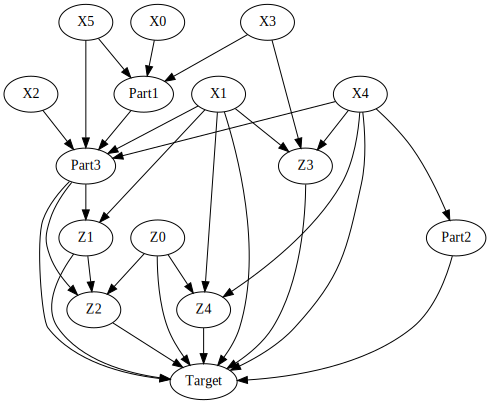

In [210]:
bobn_utils.draw(post_proc)


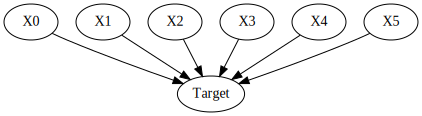

In [211]:
bobn_utils.draw(baseline_dag)

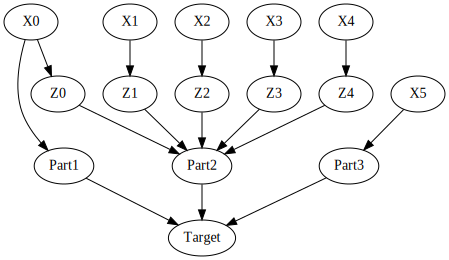

In [212]:
bobn_utils.draw(golden_dag)